# Model

Given that a crime happened associated to a 
('latitude','longitude','year','holiday','hour','no_of_month','Day_of_month','no_of_weekday', 'premise') tuple,
what's the relative probability for that crime to be a given law category?

## Setup

In [2]:
import numpy as np
import pandas as pd

from IPython.display import display

import matplotlib  
import matplotlib.pyplot as plt  
from matplotlib import rcParams

import seaborn as sns
sns.set(style='ticks', palette='Set2')

from plotnine import *
import pandas.tseries

/Users/bernadett/miniconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [4]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [5]:
pd.set_option('display.max_rows', 999)
pd.set_option('display.max_columns', 9999)

## Dataset

Preparing the dataset for prediction we drop missing values for columns premise, occurence, borough.

In [6]:
# Retrieving Data

df=pd.read_csv('cleaned.csv')
df = df[df.premise.notnull() & df.occurence.notnull() & df.borough.notnull()]
df.head(1)

,from_date,from_time,to_date,to_time,offense,offense_description,law_category,occurence,premise,borough,latitude,longitude,year,Month,weekday,holiday,hour,time_str,time,no_of_month,Day_of_month,no_of_weekday,offense_cutoff
0,2017-03-31,23:30:00,NaN,NaN,HARRASSMENT 2,"HARASSMENT,SUBD 3,4,5",VIOLATION,INSIDE,RESIDENCE - APT. HOUSE,BROOKLYN,40.638018,-73.898491,2017,Mar,Friday,0,23,2017-03-31 23:30:00,2017-03-31 23:30:00,3,31,4,HARRASSMENT 2


## Preprocessing

Based on our assumption we created a new classification type for premise and use this variable as a feature in our model.

In [7]:
premise_map = {
  'ABANDONED BUILDING': 'BUILDING',
  'AIRPORT TERMINAL': 'TRANSPORTATION',
  'ATM': 'BANK',
  'BANK': 'BANK',
  'BAR/NIGHT CLUB': 'CLUB',
  'BEAUTY & NAIL SALON': 'BUSINESS',
  'BOOK/CARD': 'BUSINESS',
  'BRIDGE': 'STREET',
  'BUS (NYC TRANSIT)': 'TRANSPORTATION',
  'BUS (OTHER)': 'TRANSPORTATION',
  'BUS STOP': 'TRANSPORTATION',
  'BUS TERMINAL': 'TRANSPORTATION',
  'CANDY STORE': 'BUSINESS',
  'CEMETERY': 'LANDMARK',
  'CHAIN STORE': 'BUSINESS',
  'CHECK CASHING BUSINESS': 'BANK',
  'CHURCH': 'CHURCH',
  'CLOTHING/BOUTIQUE': 'BUSINESS',
  'COMMERCIAL BUILDING': 'BUSINESS',
  'CONSTRUCTION SITE': 'LANDMARK',
  'DEPARTMENT STORE': 'BUSINESS',
  'DOCTOR/DENTIST OFFICE': 'BUSINESS',
  'DRUG STORE': 'BUSINESS',
  'DRY CLEANER/LAUNDRY': 'BUSINESS',
  'FACTORY/WAREHOUSE': 'BUSINESS',
  'FAST FOOD': 'BUSINESS',
  'FERRY/FERRY TERMINAL': 'TRANSPORTATION',
  'FOOD SUPERMARKET': 'BUSINESS',
  'GAS STATION': 'BUSINESS',
  'GROCERY/BODEGA': 'BUSINESS',
  'GYM/FITNESS FACILITY': 'BUSINESS',
  'HIGHWAY/PARKWAY': 'STREET',
  'HOSPITAL': 'HOSPITAL',
  'HOTEL/MOTEL': 'HOTEL',
  'JEWELRY': 'BUSINESS',
  'LIQUOR STORE': 'BUSINESS',
  'LOAN COMPANY': 'BANK',
  'MARINA/PIER': 'TRANSPORTATION',
  'MOSQUE': 'CHURCH',
  'OPEN AREAS (OPEN LOTS)': 'LANDMARK',
  'OTHER': 'OTHER',
  'OTHER HOUSE OF WORSHIP': 'CHURCH',
  'PARK/PLAYGROUND': 'LANDMARK',
  'PARKING LOT/GARAGE (PRIVATE)': 'PARKING',
  'PARKING LOT/GARAGE (PUBLIC)': 'PARKING',
  'PHOTO/COPY': 'BUSINESS',
  'PRIVATE/PAROCHIAL SCHOOL': 'CHURCH',
  'PUBLIC BUILDING': 'BUILDING',
  'PUBLIC SCHOOL': 'SCHOOL',
  'RESIDENCE - APT. HOUSE': 'RESIDENCE',
  'RESIDENCE - PUBLIC HOUSING': 'RESIDENCE',
  'RESIDENCE-HOUSE': 'RESIDENCE',
  'RESTAURANT/DINER': 'BUSINESS',
  'SHOE': 'BUSINESS',
  'SMALL MERCHANT': 'BUSINESS',
  'SOCIAL CLUB/POLICY': 'BUILDING',
  'STORAGE FACILITY': 'BUSINESS',
  'STORE UNCLASSIFIED': 'BUSINESS',
  'STREET': 'STREET',
  'SYNAGOGUE': 'CHURCH',
  'TAXI (LIVERY LICENSED)': 'TAXI',
  'TAXI (YELLOW LICENSED)': 'TAXI',
  'TAXI/LIVERY (UNLICENSED)': 'TAXI',
  'TELECOMM. STORE': 'BUSINESS',
  'TRAMWAY': 'TRANSPORTATION',
  'TRANSIT - NYC SUBWAY': 'TRANSPORTATION',
  'TRANSIT FACILITY (OTHER)': 'TRANSPORTATION',
  'TUNNEL': 'STREET',
  'VARIETY STORE': 'BUSINESS',
  'VIDEO STORE': 'BUSINESS'
}

We encoded categorical data for premise and gave the target and feature datasets for our model.

In [8]:
dft = df.copy()
dft.drop(['from_date', 'from_time', 'to_date', 'to_time', 'offense', 'borough', 'occurence', 'offense_description','Month','weekday', 'time_str', 'offense_cutoff', 'time'], axis = 1, inplace = True)
display(dft.head(1))

law_categories = dft.law_category.unique()
law_category_encoder = dict(zip(law_categories, range(len(law_categories))))
law_category_decoder = dict(zip(range(len(law_categories)), law_categories))

dft['law_category'] = dft.law_category.map(lambda v: law_category_encoder[v])
dft['premise'] = dft.premise.map(lambda v: premise_map[v])

dft = pd.get_dummies(dft, prefix="", prefix_sep="", columns=["premise"])
dft.head(1)

,law_category,premise,latitude,longitude,year,holiday,hour,no_of_month,Day_of_month,no_of_weekday
0,VIOLATION,RESIDENCE - APT. HOUSE,40.638018,-73.898491,2017,0,23,3,31,4


,law_category,latitude,longitude,year,holiday,hour,no_of_month,Day_of_month,no_of_weekday,BANK,BUILDING,BUSINESS,CHURCH,CLUB,HOSPITAL,HOTEL,LANDMARK,OTHER,PARKING,RESIDENCE,SCHOOL,STREET,TAXI,TRANSPORTATION
0,0,40.638018,-73.898491,2017,0,23,3,31,4,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


#### Train test split

We used stratified sampling method as the data for the misdemeanor category has more samples than the other groups.  
This can help dealing with class imbalance.

In [9]:
from sklearn.cross_validation import train_test_split

# stratified sample
dft_sample = pd.concat([
    dft[dft.law_category==0].sample(10000, random_state=1),
    dft[dft.law_category==1].sample(10000, random_state=1),
    dft[dft.law_category==2].sample(10000, random_state=1)
])

features_list = dft_sample.drop(['law_category','year'],axis=1).columns.values

X = dft_sample[features_list].values
y = dft_sample['law_category'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

/Users/bernadett/miniconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Feature correlation

In [10]:
dft_sample.drop(['year'],axis=1).corr()

,law_category,latitude,longitude,holiday,hour,no_of_month,Day_of_month,no_of_weekday,BANK,BUILDING,BUSINESS,CHURCH,CLUB,HOSPITAL,HOTEL,LANDMARK,OTHER,PARKING,RESIDENCE,SCHOOL,STREET,TAXI,TRANSPORTATION
law_category,1.000000,0.027490,-0.017482,-0.005939,-0.018604,0.010620,-0.000005,0.017459,0.003881,0.024186,0.127715,-0.007347,0.020214,-0.022184,0.001057,0.006451,-0.003370,0.040437,-0.177024,-0.064889,0.108050,0.009290,0.004529
latitude,0.027490,1.000000,0.337716,-0.005277,-0.003792,-0.019521,0.005118,0.004607,0.004541,0.000101,0.000261,-0.010186,0.004792,0.000367,0.006869,0.002447,0.008271,-0.004959,-0.016419,0.016573,0.008951,0.007602,0.001679
longitude,-0.017482,0.337716,1.000000,-0.004054,0.009163,-0.010889,0.002063,0.009955,-0.013439,-0.019011,-0.087499,-0.015661,-0.051634,-0.007870,-0.031033,-0.012845,0.010232,0.016770,0.073710,0.001879,0.018742,-0.007116,-0.034100
holiday,-0.005939,-0.005277,-0.004054,1.000000,-0.012085,-0.007399,-0.046878,-0.180098,-0.009584,0.001709,-0.007160,-0.005309,-0.002254,-0.003853,-0.005337,0.003001,-0.008212,0.004674,0.019252,-0.019181,-0.002346,-0.006723,-0.009206
hour,-0.018604,-0.003792,0.009163,-0.012085,1.000000,-0.001263,0.020652,-0.051547,-0.012261,-0.012301,0.050912,0.008164,-0.094968,-0.003633,-0.010409,0.007384,-0.009700,0.013283,-0.018285,-0.031183,0.021439,-0.012744,-0.001565
no_of_month,0.010620,-0.019521,-0.010889,-0.007399,-0.001263,1.000000,0.020614,0.000186,-0.009017,0.003123,0.004942,-0.002103,-0.007062,-0.002855,0.000375,0.011338,-0.001839,0.007942,-0.016365,-0.009878,0.020020,-0.003266,0.002269
Day_of_month,-0.000005,0.005118,0.002063,-0.046878,0.020652,0.020614,1.000000,-0.003697,0.007627,0.000649,0.005127,-0.012728,0.007677,0.007456,0.002401,0.002259,0.005025,0.002060,-0.008350,-0.013881,0.001959,0.005044,0.008096
no_of_weekday,0.017459,0.004607,0.009955,-0.180098,-0.051547,0.000186,-0.003697,1.000000,-0.015733,0.000959,-0.022248,-0.000477,0.054467,-0.008435,0.013264,-0.009931,-0.002552,0.002372,0.002448,-0.060791,0.027467,0.002309,-0.003213
BANK,0.003881,0.004541,-0.013439,-0.009584,-0.012261,-0.009017,0.007627,-0.015733,1.000000,-0.007352,-0.037094,-0.005678,-0.009891,-0.006909,-0.006585,-0.006474,-0.014812,-0.009089,-0.089416,-0.011796,-0.042005,-0.003358,-0.004597
BUILDING,0.024186,0.000101,-0.019011,0.001709,-0.012301,0.003123,0.000649,0.000959,-0.007352,1.000000,-0.037957,-0.005810,-0.010121,-0.007070,-0.006739,-0.006625,-0.015157,-0.009300,-0.091496,-0.012071,-0.042983,-0.003436,-0.004704


In [14]:
cols.to

array(['xlaw_category', 'xlatitude', 'xlongitude', 'xholiday', 'xhour',
       'xno_of_month', 'xDay_of_month', 'xno_of_weekday', 'xBANK',
       'xBUILDING', 'xBUSINESS', 'xCHURCH', 'xCLUB', 'xHOSPITAL', 'xHOTEL',
       'xLANDMARK', 'xOTHER', 'xPARKING', 'xRESIDENCE', 'xSCHOOL',
       'xSTREET', 'xTAXI', 'xTRANSPORTATION'], dtype=object)

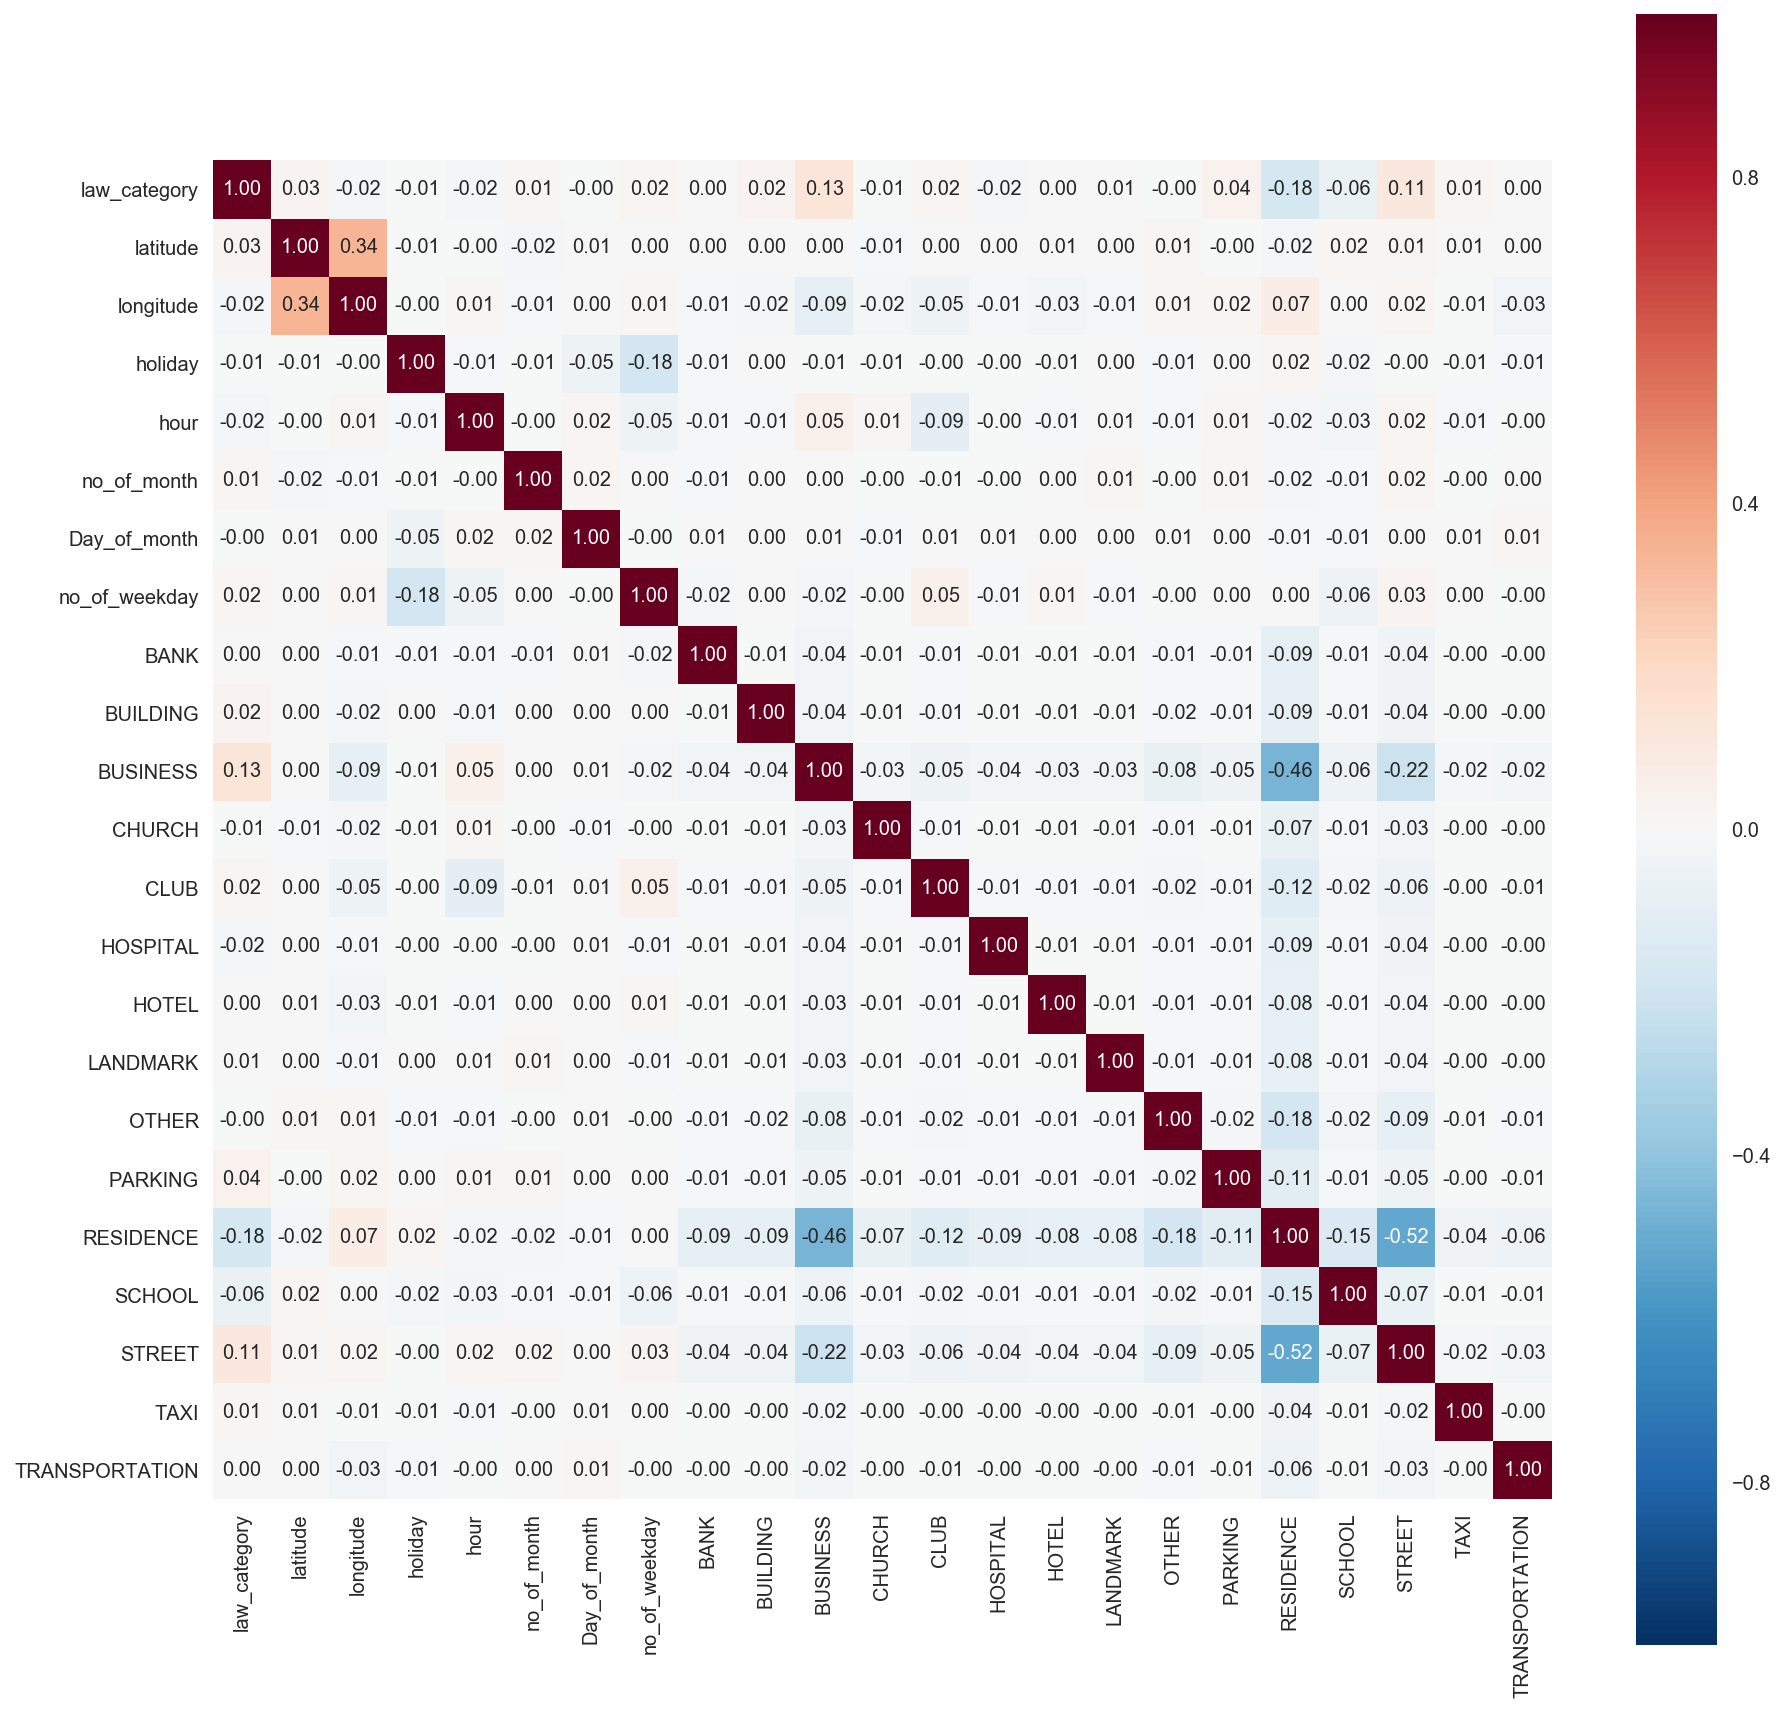

In [16]:
heatmap_df=dft_sample.drop(['year'],axis=1)
cols = heatmap_df.columns.values.tolist()
cm = np.corrcoef(heatmap_df.values.T)
sns.set(font_scale=1.0)
plt.rcParams['figure.figsize']=15,15
sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols, xticklabels=cols)

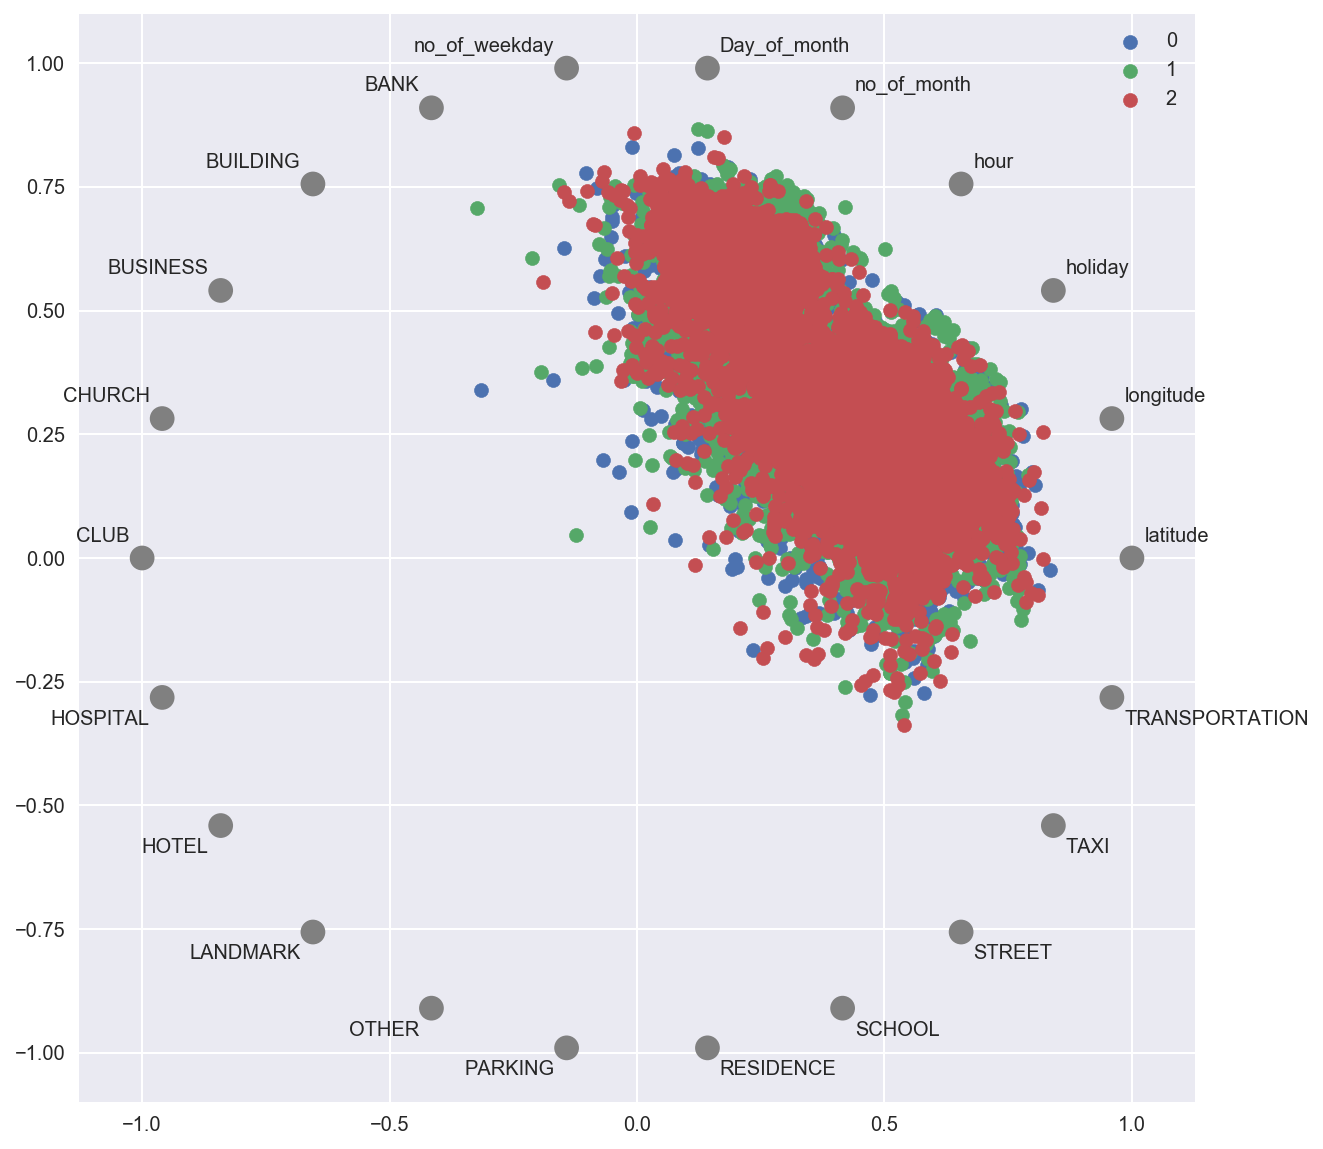

In [17]:
from pandas.plotting import radviz

plt.rcParams['figure.figsize']=10,10
radviz(dft_sample.drop(['year'],axis=1), 'law_category', color=sns.color_palette())

### Model selection

We're going to be using [logloss](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.log_loss.html) to evaluate our classifiers as we're interested in predicting probabilities

In [29]:
from sklearn.metrics import log_loss, accuracy_score, f1_score

def eval_classifier(clf):
    y_pred = clf.predict(X_test)
    y_pred_prob = clf.predict_proba(X_test)
    
    logloss = log_loss(y_test, y_pred_prob, labels=clf.classes_)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average="weighted")
    
    print(type(clf).__name__, "logloss=%s accuracy=%s f1=%s" % (logloss, accuracy, f1))

In [30]:
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

classifiers = [
    LogisticRegression(),
    GaussianNB(),
    RandomForestClassifier(n_estimators=500),
    XGBClassifier(n_estimators=500)
]

for clf in classifiers:
    clf.fit(X_train, y_train)
    eval_classifier(clf)

LogisticRegression logloss=1.06387514996 accuracy=0.432266666667 f1=0.407343330876
GaussianNB logloss=2.49735028818 accuracy=0.428 f1=0.367060877202
RandomForestClassifier logloss=1.0806814516 accuracy=0.415466666667 f1=0.413159079056
XGBClassifier logloss=1.05670100907 accuracy=0.431066666667 f1=0.425059000785


Importance of feature in our model

In [31]:
dff = pd.DataFrame(list(zip(features_list, clf.feature_importances_)), columns=['feature', 'importance'])
dff.set_index('feature', inplace=True)
dff.sort_values(by='importance', ascending=False)

,importance
feature,
latitude,0.303408
longitude,0.286668
hour,0.108808
Day_of_month,0.083101
no_of_month,0.056198
no_of_weekday,0.053109
STREET,0.016142
RESIDENCE,0.013850
BUSINESS,0.012654


Attempting to use a Voting classifier model in order to combine the streghts of the models we tried.

In [33]:
from sklearn.ensemble import VotingClassifier

classfier_names = [type(c).__name__ for c in classifiers]
estimators = list(zip(classfier_names, classifiers))

clf = VotingClassifier(estimators=estimators, voting='soft')
clf.fit(X_train, y_train)
eval_classifier(clf)

VotingClassifier logloss=1.07121739258 accuracy=0.431466666667 f1=0.379026261563


The voting model didn't improve on accuracy.  
Overall, RandomForestClassifier seems to be a sensible choice (especially as it's faster to train than XGBClassifier)

### Evaluate our model

5-split cross validation in order to check if the model is not overfitting

In [34]:
# cross validation

from sklearn.cross_validation import cross_val_score
# from sklearn.metrics import log_loss
from sklearn import metrics

clf = RandomForestClassifier(n_estimators=500)
cross_val_score(clf, X, y, cv=5, scoring="neg_log_loss")

array([-1.08145122, -1.0799805 , -1.08646534, -1.08161562, -1.08256913])

Confusion matrix

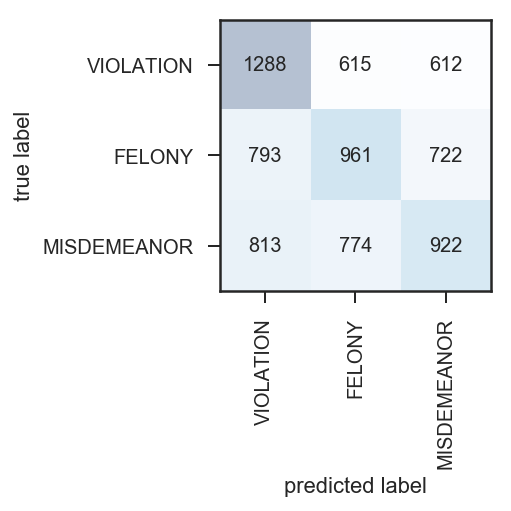

In [16]:
from mlxtend.plotting import plot_confusion_matrix
from mlxtend.evaluate import confusion_matrix

clf = RandomForestClassifier(n_estimators=500)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

cm = confusion_matrix(y_target=y_test, y_predicted=y_pred, binary=False)

fig, ax = plot_confusion_matrix(conf_mat=cm)

classes = law_categories
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=90)
plt.yticks(tick_marks, classes)

plt.show()

Nevertheless, the model is not suitable for predicting the exact law category due to the large false positives and negatives.  
It seems to be better suited as a model to predict probabilities though (logloss around 1)

Classification report

In [48]:
from sklearn.metrics import classification_report

clf = RandomForestClassifier(n_estimators=500)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred, target_names=law_categories))

             precision    recall  f1-score   support

  VIOLATION       0.44      0.51      0.47      2515
     FELONY       0.41      0.39      0.40      2476
MISDEMEANOR       0.41      0.36      0.38      2509

avg / total       0.42      0.42      0.42      7500



ROC curve

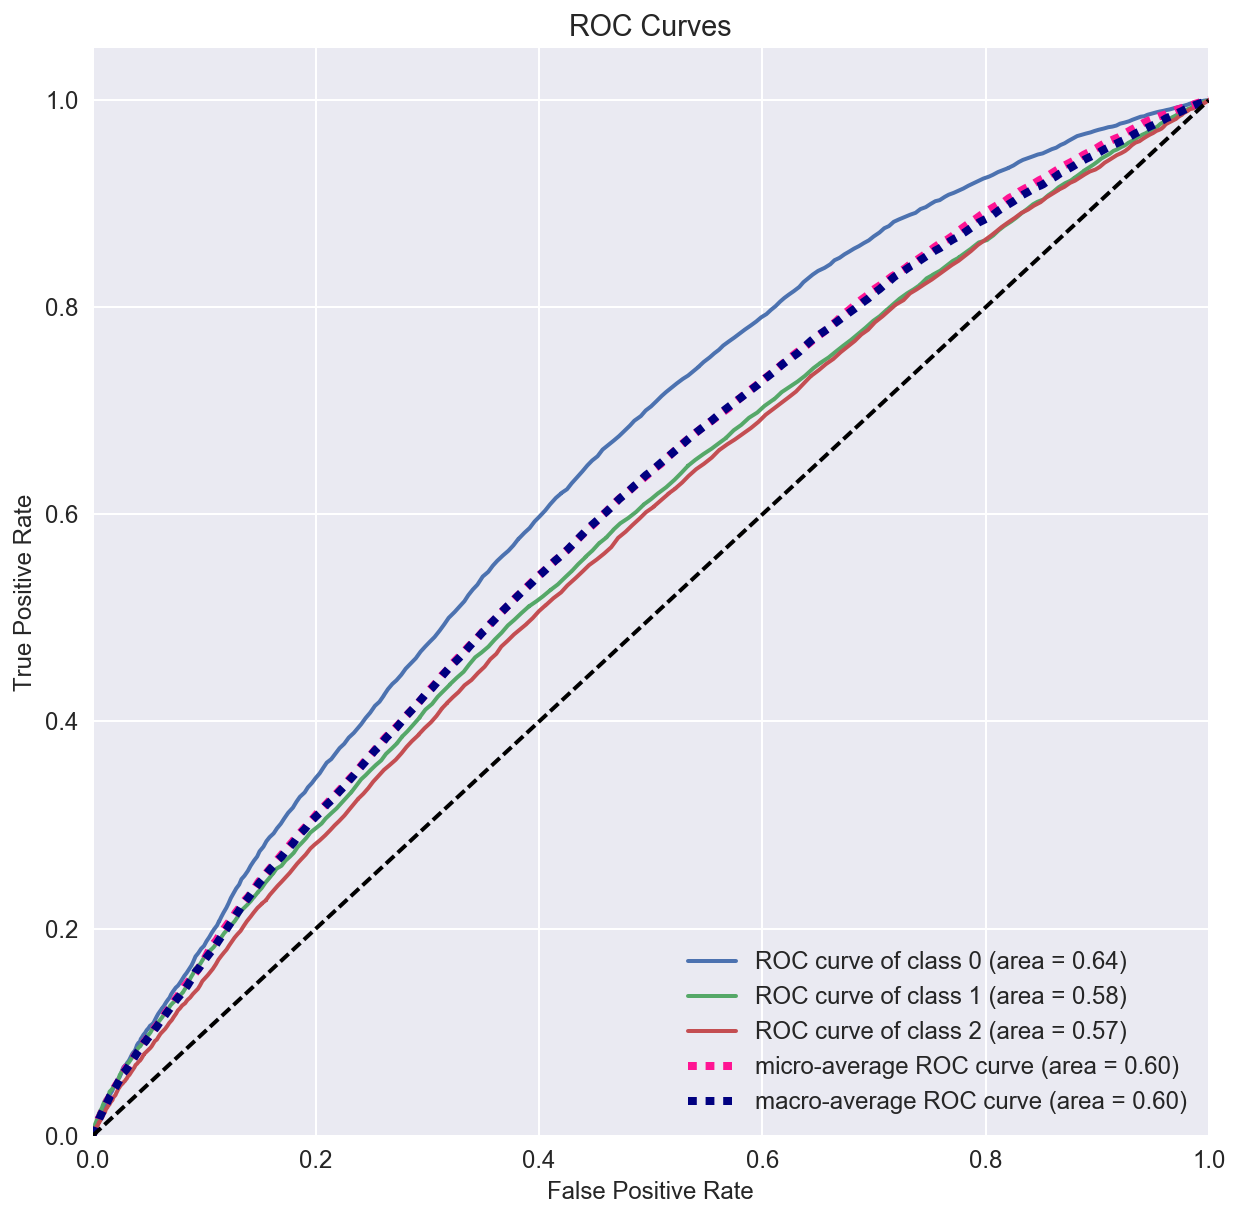

In [49]:
from scikitplot import classifier_factory

clf = RandomForestClassifier(n_estimators=500)
classifier_factory(clf)
clf.plot_roc_curve(X, y, random_state=1)
plt.show()

Again, the model doesn't perform well for predicting classes precisely (areas are above 0.5, which mean the model is not just guessing, but the performance is not great)

In [57]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred, pos_label=2)
roc_auc = auc(fpr, tpr)

print("Area under the ROC curve : %f" % roc_auc)

Area under the ROC curve : 0.558600


In [60]:
i = np.arange(len(tpr))
roc = pd.DataFrame({"fpr or (1-specificity)" : pd.Series(fpr, index=i),'tpr or sensitivity' : pd.Series(tpr, index = i), '1-fpr' : pd.Series(1-fpr, index = i), 'tf' : pd.Series(tpr - (1-fpr), index = i), 'thresholds' : pd.Series(thresholds, index = i)})
roc.iloc[(roc.tf-0).abs().argsort()[:1]]

,1-fpr,fpr or (1-specificity),tf,thresholds,tpr or sensitivity
2,0.415949,0.584051,0.253242,1,0.669191


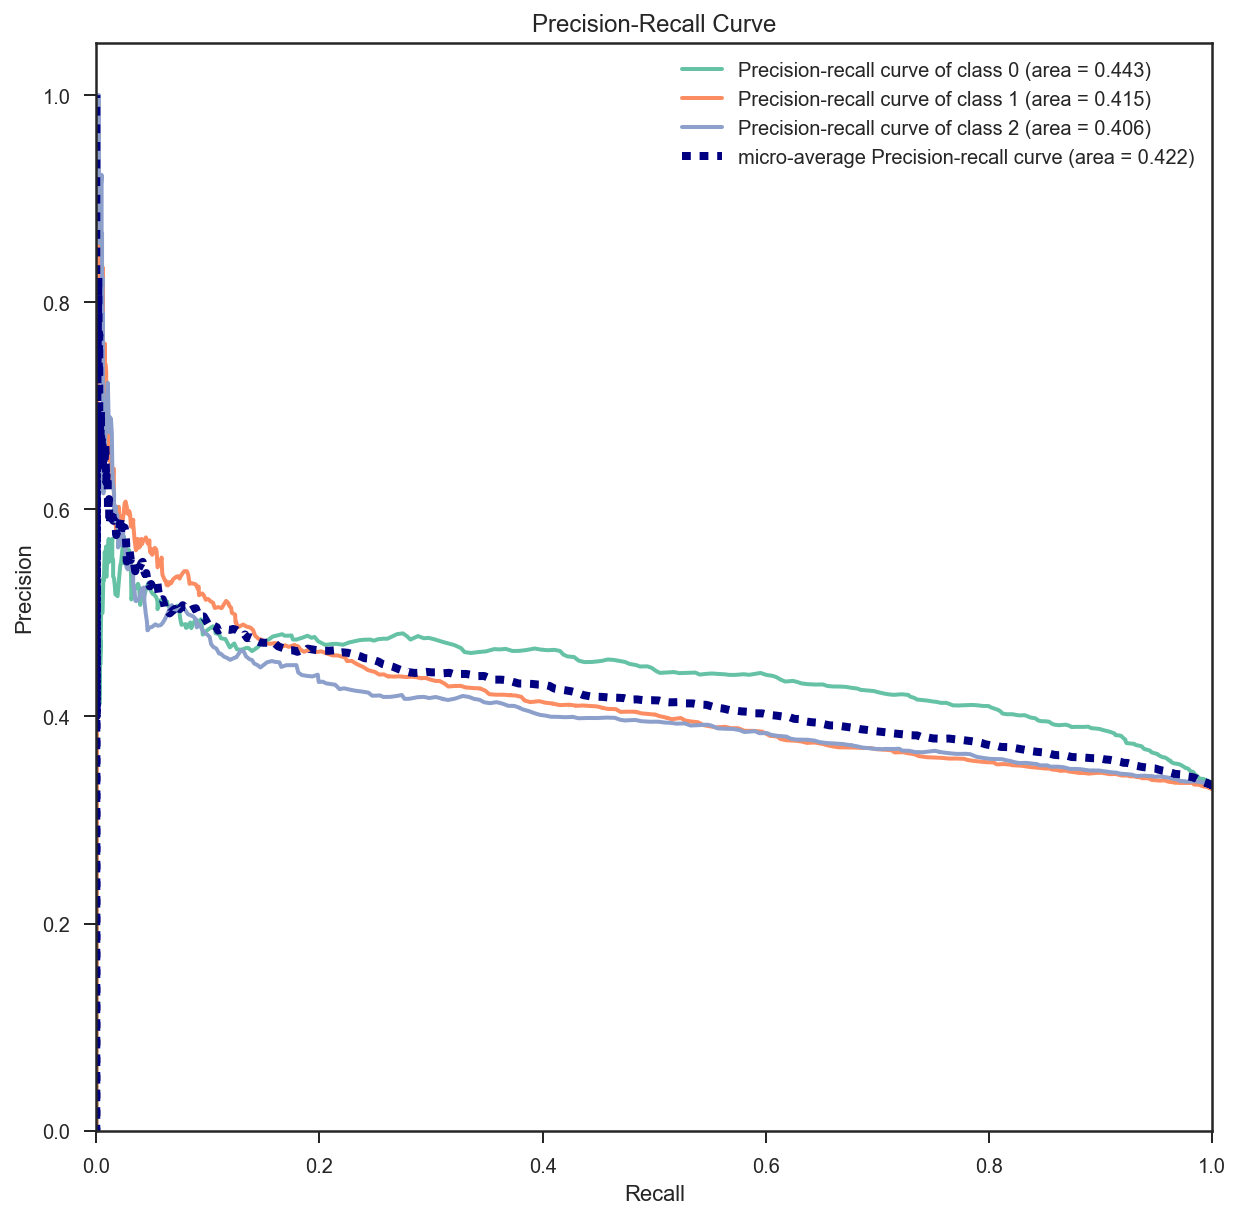

In [19]:
import scikitplot.plotters as skplt

clf = RandomForestClassifier(n_estimators=500)
clf.fit(X_train, y_train)
y_pred_prob = clf.predict_proba(X_test)

skplt.plot_precision_recall_curve(y_test, y_pred_prob)
plt.show()

The areas of the classes are under 0.5 for all categories, meaning that we can't interpret the performance of the model by using the precision curve alone. Also, the curves seem to be "noise", which means that the model is not predicting classes well. This is expected to some extent, as the model is not performant for predicting specific classes.